<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Explore-other-reward-functions" data-toc-modified-id="Explore-other-reward-functions-1">Explore other reward functions</a></span><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1.1">Goal</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2">Imports</a></span></li><li><span><a href="#Code" data-toc-modified-id="Code-1.3">Code</a></span><ul class="toc-item"><li><span><a href="#Data-generation" data-toc-modified-id="Data-generation-1.3.1">Data generation</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.3.2">Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-1.3.3">Visualization</a></span></li></ul></li><li><span><a href="#risk_averse_goose" data-toc-modified-id="risk_averse_goose-1.4">risk_averse_goose</a></span><ul class="toc-item"><li><span><a href="#Generation" data-toc-modified-id="Generation-1.4.1">Generation</a></span><ul class="toc-item"><li><span><a href="#Epsilon-0.02" data-toc-modified-id="Epsilon-0.02-1.4.1.1">Epsilon 0.02</a></span></li><li><span><a href="#Epsilon-0.05" data-toc-modified-id="Epsilon-0.05-1.4.1.2">Epsilon 0.05</a></span></li><li><span><a href="#Epsilon-0.25" data-toc-modified-id="Epsilon-0.25-1.4.1.3">Epsilon 0.25</a></span></li><li><span><a href="#Epsilon-0.50" data-toc-modified-id="Epsilon-0.50-1.4.1.4">Epsilon 0.50</a></span></li></ul></li><li><span><a href="#reward_-4_4" data-toc-modified-id="reward_-4_4-1.4.2">reward_-4_4</a></span><ul class="toc-item"><li><span><a href="#Multiagent-setup" data-toc-modified-id="Multiagent-setup-1.4.2.1">Multiagent setup</a></span></li><li><span><a href="#Single-agent" data-toc-modified-id="Single-agent-1.4.2.2">Single agent</a></span></li><li><span><a href="#Play-against-risk_averse_goose" data-toc-modified-id="Play-against-risk_averse_goose-1.4.2.3">Play against risk_averse_goose</a></span></li><li><span><a href="#Game-visualization" data-toc-modified-id="Game-visualization-1.4.2.4">Game visualization</a></span></li></ul></li></ul></li><li><span><a href="#Verify-that-data-is-created-correctly" data-toc-modified-id="Verify-that-data-is-created-correctly-1.5">Verify that data is created correctly</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-1.6">Summary</a></span></li></ul></li></ul></div>

# Explore other reward functions

## Goal

The goal of this notebooks is to continue learning about the Q value function, but trying other reward methods.

This is a continuation of notebook 004, which had become too big. In this notebook I will split the functionality
of playing games and generating data from training from those games.

## Imports

In [1]:
# Use this to reload changes in python scripts
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import kaggle_environments
from kaggle_environments import make
from kaggle_environments import evaluate
from kaggle_environments.envs.hungry_geese.hungry_geese import Action
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import pandas as pd
from tqdm.notebook import tqdm
import time
from itertools import permutations
from functools import partial
import gc
from concurrent.futures import ProcessPoolExecutor
import json
import logging

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
import tensorflow.keras as keras

from hungry_geese import GameState
from hungry_geese.state import make_board_egocentric, get_head_position, combine_data, horizontal_simmetry, vertical_simmetry
from hungry_geese.utils import ACTIONS, opposite_action, get_timestamp, log_ram_usage, configure_logging
from hungry_geese.definitions import ACTION_TO_IDX
from hungry_geese.agents import EpsilonAgent, QValueAgent
from hungry_geese.evaluation import play_matches_in_parallel, monitor_progress
from hungry_geese.elo import EloRanking
from hungry_geese.model import simple_model, create_model_for_training

%config Completer.use_jedi = False

Loading environment football failed: No module named 'gfootball'


In [3]:
plt.plot()
plt.close('all')
plt.rcParams["figure.figsize"] = (30, 5)  
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 16

configure_logging(logging.INFO)
logger = logging.getLogger(__name__)

## Code

### Data generation

In [4]:
def play_matches_in_parallel_and_save_history(agents, max_workers=20, n_matches=1000,
                                              running_on_notebook=True):
    """
    Plays n_matches in parallel using ProcessPoolExecutor

    Parameters
    -----------
    agents : list
        List of the agents that we will use for playing
    """
    log_ram_usage()
    output_path = get_games_output_path(agents, n_matches)
    assert not os.path.exists(output_path), 'Output path already exists: %s' % output_path
    with ProcessPoolExecutor(max_workers=max_workers) as pool:
        matches_results = []
        submits = []
        for i in range(n_matches):
            submits.append(pool.submit(play_game, agents=agents))
        monitor_progress(submits, running_on_notebook)
        matches_results = [submit.result() for submit in submits]
    
    log_ram_usage()
    logger.info('saving matches to json: %s' % output_path)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, 'w') as f:
        json.dump(matches_results, f)
        
    del submits
    del matches_results
    gc.collect()
    log_ram_usage()

def play_game(agents):
    env = make("hungry_geese")
    return env.run(agents=agents)

def get_games_output_path(agents, n_matches):
    output_path = '/mnt/hdd0/Kaggle/hungry_geese/games/%s_vs_%s_matches_%i.json' % (
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_path

In [5]:
def test_agent(agent):
    print('Testing agent: %s' % agent)
    env = make('hungry_geese', debug=True)
    env.run([agent]*4)

In [6]:
def create_train_data(agents, n_matches, reward_name, agent_idx_range=None):
    """
    Creates train data without any simmetry
    
    Parameters
    ----------
    agents : list of str
        Names or paths of the agents
    n_matches : int
        Number of matches to play
    reward_name : str
        Name of the reward function that we want to use
    max_workers : int
    agent_idx_range : list of int
        Idx of the agents we want to use for collecting data, if None all the agents
        will be used
    """
    output_path = get_games_output_path(agents, n_matches)
    if not os.path.exists(output_path):
        play_matches_in_parallel_and_save_history(agents, n_matches=n_matches)
    else:
        logger.info('Matches already saved in disk, proceed to loading')
    with open(output_path, 'r') as f:
        matches_results = json.load(f)
    
    log_ram_usage()
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(reward_name=reward_name)
    train_data = []
    agent_idx_range = agent_idx_range or list(range(4))
    for _ in tqdm(range(len(matches_results)), desc='Creating game data'):
        match = matches_results[0]
        for idx in agent_idx_range:
            state.reset()
            for step_idx, step in enumerate(match):
                observation = step[0]['observation'].copy()
                observation['index'] = idx
                state.update(observation, conf)
                if step_idx:
                    state.add_action(step[idx]['action'])
                if not observation['geese'][idx]:
                    break
            train_data.append(state.prepare_data_for_training())
        del matches_results[0]
        
    log_ram_usage()
    train_data = combine_data(train_data)
    logger.info('Size of the boards is %.1f GB' % (train_data[0].nbytes/1e9))
    output_file = get_data_output_path(agents, n_matches, reward_name)
    logger.info('Saving data on: %s' % output_file)
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    np.savez_compressed(output_file, boards=train_data[0], features=train_data[1], actions=train_data[2], rewards=train_data[3])
    del state
    del train_data
    gc.collect()
    log_ram_usage()
    
def get_data_output_path(agents, n_matches, reward_name):
    output_file = '/mnt/hdd0/Kaggle/hungry_geese/data/%s/%s_vs_%s_matches_%i.npz' % (
        reward_name,
        os.path.splitext(os.path.basename(agents[0]))[0], 
        os.path.splitext(os.path.basename(agents[1]))[0], 
        n_matches)
    return output_file

### Evaluation

In [7]:
initial_elo_ranking = pd.read_csv('../data/elo_ranking.csv', index_col='model')
initial_elo_ranking

,ranking
model,
boilergoose,1269
besthoarder,1227
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
greedyhoarder,766
random_plus,706


In [8]:
agents = {
    'random': 'random',
    'random_plus': '../forum/agents/random_plus.py',
    'greedy': 'greedy',
    'risk_averse_goose': '../forum/agents/risk_averse_goose.py',
    'goose_on_a_healthy_diet': '../forum/agents/goose_on_a_healthy_diet.py',
    'straightforward_bfs': '../forum/agents/straightforward_bfs.py',
    'boilergoose': '../forum/agents/boilergoose.py',
    'crazy_goose': '../forum/agents/crazy_goose.py',
    'besthoarder': '../forum/agents/besthoarder.py',
    'greedyhoarder': '../forum/agents/greedyhoarder.py',
    'q_value': '/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/random_plus.py',
}

In [9]:
def evaluate_agent(new_agent, adversary_agents, n_matches, single_agent=True, max_workers=20, run_agent_test=False):
    agent_name = list(new_agent.keys())[0]
    # I have found that for certain agents if the test is run then evaluation is frozen
    if run_agent_test: test_agent(new_agent[agent_name])
    reduced_agents_set = new_agent.copy()
    for adversary_agent in adversary_agents:
        reduced_agents_set[adversary_agent] = agents[adversary_agent]
    
    if single_agent:
        sample_agents_func = lambda: [agent_name] + np.random.choice(adversary_agents, 3).tolist()
    else:
        def sample_agents_func():
            while 1:
                sampled_agents = [agent_name] + np.random.choice(adversary_agents + [agent_name], 3).tolist()
                if len(np.unique(sampled_agents)) >=2:
                    break
            return sampled_agents

    matches_agents, matches_results = play_matches_in_parallel(reduced_agents_set, sample_agents_func, n_matches=n_matches, max_workers=max_workers)
    return matches_agents, matches_results, reduced_agents_set
    
def compute_elo_ranking(matches_agents, matches_results, reduced_agents_set):
    initial_agent_elo = 1000
    for k in [32, 16, 8, 4, 2, 1]:
        agent_name = [name for name in reduced_agents_set if name not in initial_elo_ranking][0]
        initial_ranking = initial_elo_ranking.to_dict()['ranking']
        initial_ranking[agent_name] = initial_agent_elo
        initial_ranking = {key: initial_ranking[key] for key in reduced_agents_set}
        elo_ranking = EloRanking(initial_ranking, {agent_name}, k=k)
        for match_agents, match_results in zip(matches_agents, matches_results):
            elo_ranking.add_match(match_agents, match_results)
        initial_agent_elo = elo_ranking.summary().loc[agent_name, 'ranking']
    elo_ranking.plot()
    return elo_ranking.summary()

### Visualization

In [10]:
def plot_q_value(agent):
    values = np.array(agent.q_values)
    for idx, action in enumerate(ACTIONS):
        plt.plot(values[:, idx], label=action, alpha=0.6)
    plt.legend(loc=0)
    plt.grid(axis='x')

## risk_averse_goose

### Generation

#### Epsilon 0.02

In [19]:
n_matches = 100
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_002.py'] + \
    ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/risk_averse_goose.py']*3
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name, agent_idx_range=[0])

2021-03-20 10:50:40,564 - hungry_geese.utils - INFO - ram_memory used: 0.41 GB	 available: 54.63 GB


  0%|          | 0/100 [00:00<?, ?it/s]

2021-03-20 10:50:47,992 - hungry_geese.utils - INFO - ram_memory used: 0.51 GB	 available: 54.62 GB
2021-03-20 10:50:47,993 - __main__ - INFO - saving matches to json
2021-03-20 10:50:49,121 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 54.66 GB
2021-03-20 10:50:49,445 - hungry_geese.utils - INFO - ram_memory used: 0.48 GB	 available: 54.60 GB


Creating game data:   0%|          | 0/100 [00:00<?, ?it/s]

2021-03-20 10:50:50,266 - hungry_geese.utils - INFO - ram_memory used: 0.44 GB	 available: 54.67 GB
2021-03-20 10:50:50,287 - __main__ - INFO - Size of the boards is 0.1 GB
2021-03-20 10:50:50,288 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_100.npz
2021-03-20 10:50:50,687 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 54.67 GB


In [29]:
n_matches = 8000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_002.py'] + \
    ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/risk_averse_goose.py']*3
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name, agent_idx_range=[0])

2021-03-20 10:52:12,262 - hungry_geese.utils - INFO - ram_memory used: 0.42 GB	 available: 54.66 GB


  0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-20 11:00:17,852 - hungry_geese.utils - INFO - ram_memory used: 8.34 GB	 available: 46.54 GB
2021-03-20 11:00:17,853 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_8000.json
2021-03-20 11:01:43,184 - hungry_geese.utils - INFO - ram_memory used: 0.43 GB	 available: 54.45 GB
2021-03-20 11:02:07,252 - hungry_geese.utils - INFO - ram_memory used: 5.95 GB	 available: 48.92 GB


Creating game data:   0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-20 11:03:07,641 - hungry_geese.utils - INFO - ram_memory used: 6.20 GB	 available: 48.66 GB
2021-03-20 11:03:08,638 - __main__ - INFO - Size of the boards is 4.3 GB
2021-03-20 11:03:08,639 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_8000.npz
2021-03-20 11:03:33,164 - hungry_geese.utils - INFO - ram_memory used: 4.68 GB	 available: 50.20 GB


In [10]:
n_matches = 40000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_002.py'] + \
    ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/risk_averse_goose.py']*3
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name, agent_idx_range=[0])

2021-03-20 11:04:07,736 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 55.21 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-20 11:43:58,110 - hungry_geese.utils - INFO - ram_memory used: 39.86 GB	 available: 16.12 GB
2021-03-20 11:43:58,111 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_40000.json
2021-03-20 11:50:57,720 - hungry_geese.utils - INFO - ram_memory used: 0.45 GB	 available: 55.24 GB
2021-03-20 11:52:53,453 - hungry_geese.utils - INFO - ram_memory used: 27.99 GB	 available: 27.65 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-20 11:58:12,524 - hungry_geese.utils - INFO - ram_memory used: 29.63 GB	 available: 25.96 GB
2021-03-20 11:58:24,163 - __main__ - INFO - Size of the boards is 21.4 GB
2021-03-20 11:58:24,164 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_40000.npz
2021-03-20 12:00:27,399 - hungry_geese.utils - INFO - ram_memory used: 22.03 GB	 available: 33.75 GB


#### Epsilon 0.05

In [15]:
n_matches = 8000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_005.py'] + \
    ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/risk_averse_goose.py']*3
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name, agent_idx_range=[0])

2021-03-20 16:49:33,080 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 61.03 GB


  0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-20 16:57:10,179 - hungry_geese.utils - INFO - ram_memory used: 8.07 GB	 available: 53.34 GB
2021-03-20 16:57:10,179 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_005_vs_risk_averse_goose_matches_8000.json
2021-03-20 16:58:29,186 - hungry_geese.utils - INFO - ram_memory used: 0.37 GB	 available: 61.04 GB
2021-03-20 16:58:52,651 - hungry_geese.utils - INFO - ram_memory used: 5.74 GB	 available: 55.65 GB


Creating game data:   0%|          | 0/8000 [00:00<?, ?it/s]

2021-03-20 16:59:43,973 - hungry_geese.utils - INFO - ram_memory used: 5.51 GB	 available: 55.85 GB
2021-03-20 16:59:44,853 - __main__ - INFO - Size of the boards is 3.5 GB
2021-03-20 16:59:44,854 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_005_vs_risk_averse_goose_matches_8000.npz
2021-03-20 17:00:05,138 - hungry_geese.utils - INFO - ram_memory used: 3.94 GB	 available: 57.45 GB


In [ ]:
n_matches = 40000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_005.py'] + \
    ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/risk_averse_goose.py']*3
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name, agent_idx_range=[0])

2021-03-20 17:04:11,809 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 61.04 GB


  0%|          | 0/80000 [00:00<?, ?it/s]

#### Epsilon 0.25

In [14]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 18:50:22,177 - hungry_geese.utils - INFO - ram_memory used: 1.92 GB	 available: 62.52 GB


  0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-20 18:51:13,348 - hungry_geese.utils - INFO - ram_memory used: 2.80 GB	 available: 61.60 GB
2021-03-20 18:51:13,349 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_2000.json
2021-03-20 18:51:21,887 - hungry_geese.utils - INFO - ram_memory used: 1.92 GB	 available: 62.50 GB
2021-03-20 18:51:24,744 - hungry_geese.utils - INFO - ram_memory used: 2.53 GB	 available: 61.90 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-20 18:51:50,049 - hungry_geese.utils - INFO - ram_memory used: 2.75 GB	 available: 61.67 GB
2021-03-20 18:51:50,515 - __main__ - INFO - Size of the boards is 2.0 GB
2021-03-20 18:51:50,516 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_2000.npz
2021-03-20 18:52:00,988 - hungry_geese.utils - INFO - ram_memory used: 2.34 GB	 available: 62.07 GB


In [15]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 18:52:19,228 - hungry_geese.utils - INFO - ram_memory used: 2.34 GB	 available: 62.02 GB


  0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-20 18:56:34,546 - hungry_geese.utils - INFO - ram_memory used: 6.82 GB	 available: 57.10 GB
2021-03-20 18:56:34,547 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_10000.json
2021-03-20 18:57:15,728 - hungry_geese.utils - INFO - ram_memory used: 2.35 GB	 available: 61.44 GB
2021-03-20 18:57:27,595 - hungry_geese.utils - INFO - ram_memory used: 5.44 GB	 available: 58.34 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-20 18:59:29,653 - hungry_geese.utils - INFO - ram_memory used: 12.48 GB	 available: 51.30 GB
2021-03-20 18:59:31,975 - __main__ - INFO - Size of the boards is 9.9 GB
2021-03-20 18:59:31,976 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_10000.npz
2021-03-20 19:00:21,902 - hungry_geese.utils - INFO - ram_memory used: 10.36 GB	 available: 53.40 GB


In [18]:
n_matches = 20000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 19:19:11,826 - hungry_geese.utils - INFO - ram_memory used: 16.20 GB	 available: 47.35 GB


  0%|          | 0/20000 [00:00<?, ?it/s]

2021-03-20 19:27:29,704 - hungry_geese.utils - INFO - ram_memory used: 25.12 GB	 available: 38.44 GB
2021-03-20 19:27:29,705 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_20000.json
2021-03-20 19:28:51,605 - hungry_geese.utils - INFO - ram_memory used: 16.21 GB	 available: 47.36 GB
2021-03-20 19:29:15,126 - hungry_geese.utils - INFO - ram_memory used: 22.37 GB	 available: 41.19 GB


Creating game data:   0%|          | 0/20000 [00:00<?, ?it/s]

2021-03-20 19:33:17,479 - hungry_geese.utils - INFO - ram_memory used: 24.49 GB	 available: 39.07 GB
2021-03-20 19:33:23,348 - __main__ - INFO - Size of the boards is 19.6 GB
2021-03-20 19:33:23,350 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_20000.npz
2021-03-20 19:35:01,892 - hungry_geese.utils - INFO - ram_memory used: 20.28 GB	 available: 43.23 GB


In [11]:
n_matches = 40000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_025.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 19:40:17,006 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 63.22 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-20 19:56:59,863 - hungry_geese.utils - INFO - ram_memory used: 18.27 GB	 available: 45.05 GB
2021-03-20 19:56:59,864 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_40000.json
2021-03-20 19:59:50,638 - hungry_geese.utils - INFO - ram_memory used: 0.41 GB	 available: 62.88 GB
2021-03-20 20:00:43,053 - hungry_geese.utils - INFO - ram_memory used: 12.77 GB	 available: 50.58 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-20 20:08:54,981 - hungry_geese.utils - INFO - ram_memory used: 48.69 GB	 available: 14.45 GB
2021-03-20 20:09:54,053 - __main__ - INFO - Size of the boards is 39.3 GB
2021-03-20 20:09:54,118 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_025_vs_epsilon_risk_averse_goose_025_matches_40000.npz
2021-03-20 20:13:14,160 - hungry_geese.utils - INFO - ram_memory used: 24.29 GB	 available: 40.13 GB


#### Epsilon 0.50

In [11]:
n_matches = 2000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_050.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 18:49:03,924 - hungry_geese.utils - INFO - ram_memory used: 0.34 GB	 available: 64.14 GB


  0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-20 18:49:44,079 - hungry_geese.utils - INFO - ram_memory used: 1.05 GB	 available: 63.41 GB
2021-03-20 18:49:44,080 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_2000.json
2021-03-20 18:49:50,893 - hungry_geese.utils - INFO - ram_memory used: 0.35 GB	 available: 64.12 GB
2021-03-20 18:49:53,095 - hungry_geese.utils - INFO - ram_memory used: 0.83 GB	 available: 63.64 GB


Creating game data:   0%|          | 0/2000 [00:00<?, ?it/s]

2021-03-20 18:50:13,487 - hungry_geese.utils - INFO - ram_memory used: 2.29 GB	 available: 62.14 GB
2021-03-20 18:50:13,888 - __main__ - INFO - Size of the boards is 1.5 GB
2021-03-20 18:50:13,890 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_2000.npz
2021-03-20 18:50:22,115 - hungry_geese.utils - INFO - ram_memory used: 1.92 GB	 available: 62.54 GB


In [16]:
n_matches = 10000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_050.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 19:00:21,923 - hungry_geese.utils - INFO - ram_memory used: 10.36 GB	 available: 53.40 GB


  0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-20 19:03:39,728 - hungry_geese.utils - INFO - ram_memory used: 13.94 GB	 available: 49.80 GB
2021-03-20 19:03:39,729 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_10000.json
2021-03-20 19:04:12,042 - hungry_geese.utils - INFO - ram_memory used: 10.37 GB	 available: 53.38 GB
2021-03-20 19:04:21,493 - hungry_geese.utils - INFO - ram_memory used: 12.83 GB	 available: 50.91 GB


Creating game data:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-03-20 19:05:58,949 - hungry_geese.utils - INFO - ram_memory used: 12.26 GB	 available: 51.48 GB
2021-03-20 19:06:00,933 - __main__ - INFO - Size of the boards is 7.8 GB
2021-03-20 19:06:00,934 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_10000.npz
2021-03-20 19:06:39,888 - hungry_geese.utils - INFO - ram_memory used: 10.37 GB	 available: 53.37 GB


In [17]:
n_matches = 20000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_050.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 19:06:39,909 - hungry_geese.utils - INFO - ram_memory used: 10.37 GB	 available: 53.37 GB


  0%|          | 0/20000 [00:00<?, ?it/s]

2021-03-20 19:13:12,541 - hungry_geese.utils - INFO - ram_memory used: 17.49 GB	 available: 46.21 GB
2021-03-20 19:13:12,541 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_20000.json
2021-03-20 19:14:16,476 - hungry_geese.utils - INFO - ram_memory used: 10.37 GB	 available: 53.34 GB
2021-03-20 19:14:35,099 - hungry_geese.utils - INFO - ram_memory used: 15.29 GB	 available: 48.38 GB


Creating game data:   0%|          | 0/20000 [00:00<?, ?it/s]

2021-03-20 19:17:49,697 - hungry_geese.utils - INFO - ram_memory used: 19.98 GB	 available: 43.54 GB
2021-03-20 19:17:54,444 - __main__ - INFO - Size of the boards is 15.6 GB
2021-03-20 19:17:54,445 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_20000.npz
2021-03-20 19:19:11,805 - hungry_geese.utils - INFO - ram_memory used: 16.20 GB	 available: 47.35 GB


In [12]:
n_matches = 40000
agents = ['/mnt/hdd0/MEGA/AI/22 Kaggle/hungry_geese/forum/agents/epsilon_risk_averse_goose_050.py']*4
reward_name = 'ranking_reward_-4_4'
create_train_data(agents=agents, n_matches=n_matches, reward_name=reward_name)

2021-03-20 20:13:14,424 - hungry_geese.utils - INFO - ram_memory used: 24.29 GB	 available: 40.12 GB


  0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-20 20:26:22,409 - hungry_geese.utils - INFO - ram_memory used: 38.63 GB	 available: 24.99 GB
2021-03-20 20:26:22,410 - __main__ - INFO - saving matches to json: /mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_40000.json
2021-03-20 20:28:33,649 - hungry_geese.utils - INFO - ram_memory used: 24.33 GB	 available: 39.30 GB
2021-03-20 20:29:14,971 - hungry_geese.utils - INFO - ram_memory used: 34.21 GB	 available: 29.41 GB


Creating game data:   0%|          | 0/40000 [00:00<?, ?it/s]

2021-03-20 20:38:21,723 - hungry_geese.utils - INFO - ram_memory used: 45.03 GB	 available: 18.57 GB
2021-03-20 20:39:02,709 - __main__ - INFO - Size of the boards is 31.3 GB
2021-03-20 20:39:02,723 - __main__ - INFO - Saving data on: /mnt/hdd0/Kaggle/hungry_geese/data/ranking_reward_-4_4/epsilon_risk_averse_goose_050_vs_epsilon_risk_averse_goose_050_matches_40000.npz
2021-03-20 20:41:38,010 - hungry_geese.utils - INFO - ram_memory used: 24.85 GB	 available: 38.86 GB


### reward_-4_4 

#### Multiagent setup

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
q_value_pretrained,990
greedy,981
random_plus,706


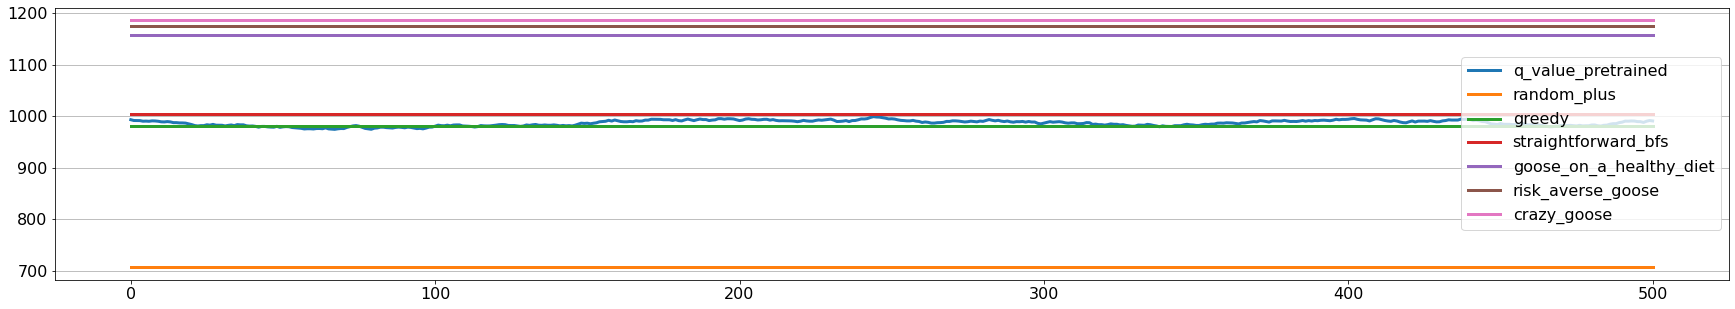

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/01_epsilon002_reward_-4_4_x16/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

Clearly a bad result.

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1012
straightforward_bfs,1004
greedy,981
random_plus,706


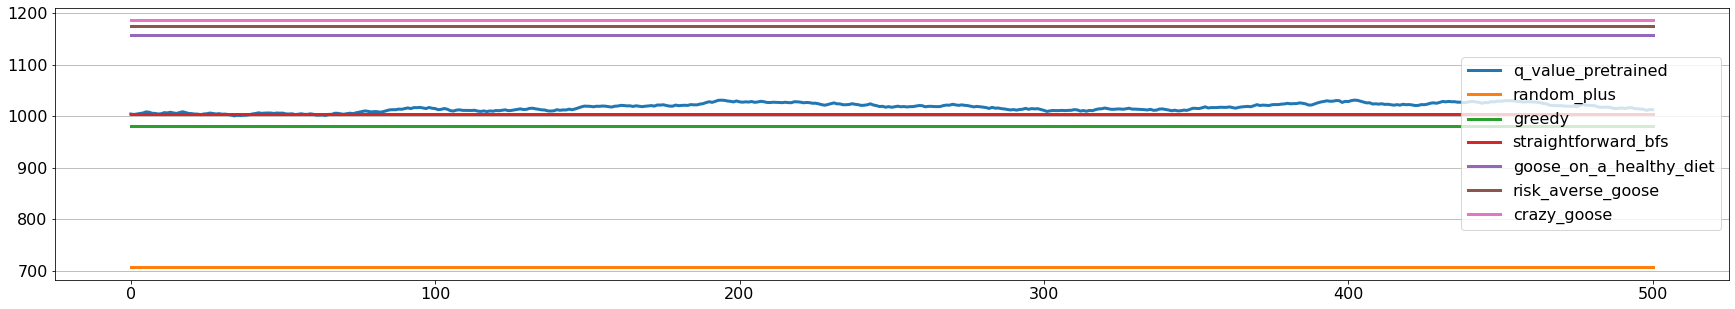

In [10]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/02_epsilon002_reward_-4_4_x128/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
straightforward_bfs,1004
greedy,981
q_value_pretrained,965
random_plus,706


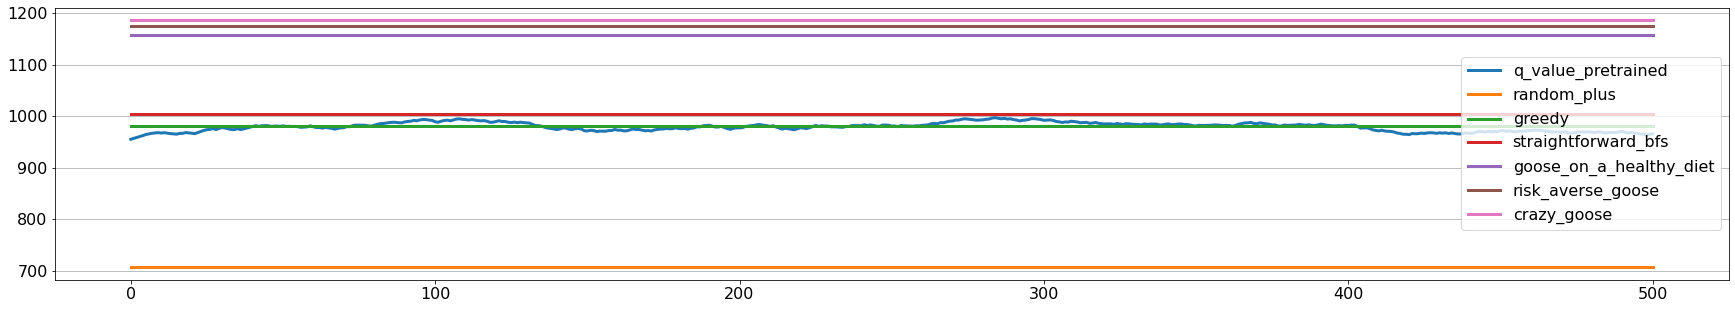

In [11]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/04_epsilon002_reward_-4_4_x128_generator_data_augmentation/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1032
straightforward_bfs,1004
greedy,981
random_plus,706


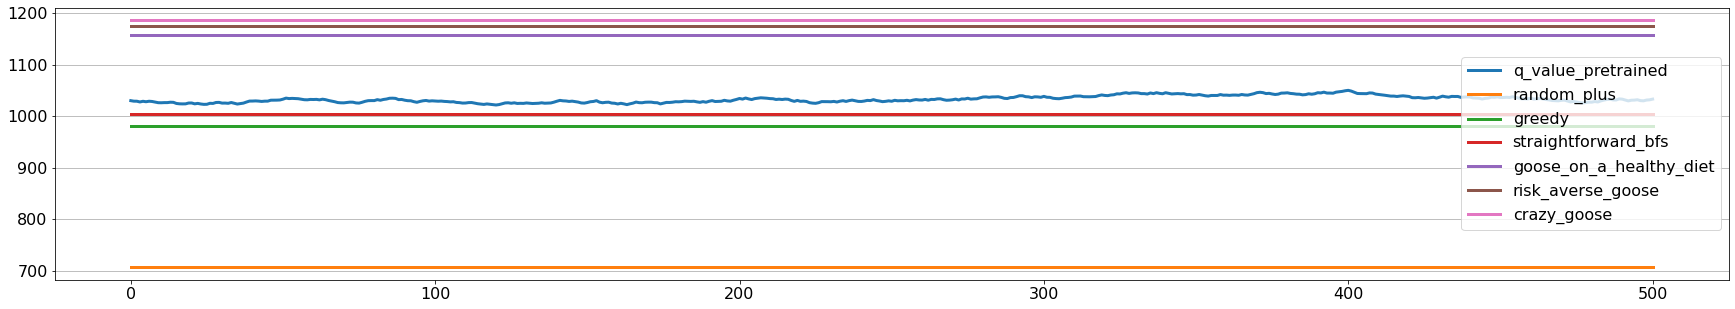

In [12]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/05_epsilon002_reward_-4_4_x128_generator_more_data_augmentation/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=False, max_workers=20)
compute_elo_ranking(*ret)

#### Single agent

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1075
straightforward_bfs,1004
greedy,981
random_plus,706


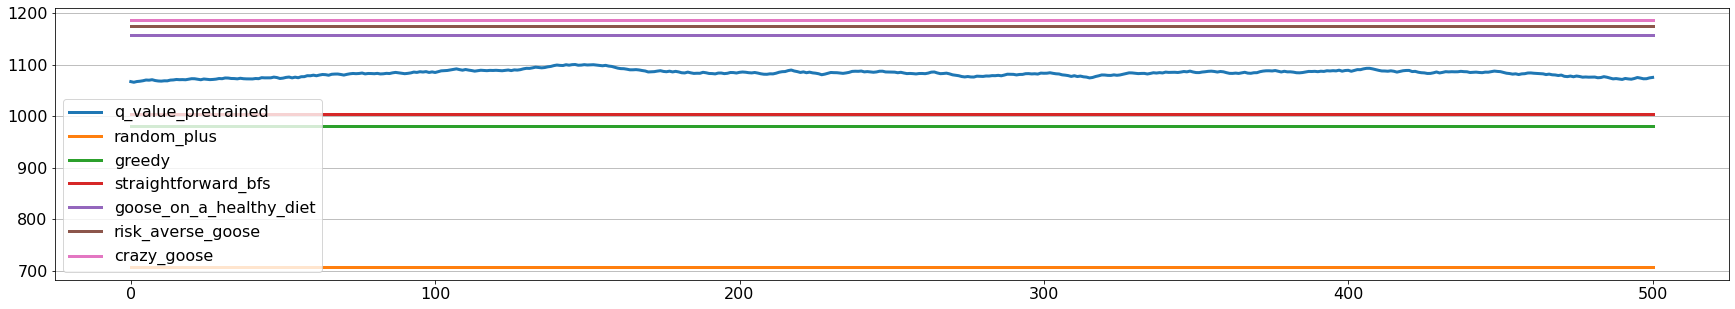

In [16]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/01_epsilon002_reward_-4_4_x16/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1077
straightforward_bfs,1004
greedy,981
random_plus,706


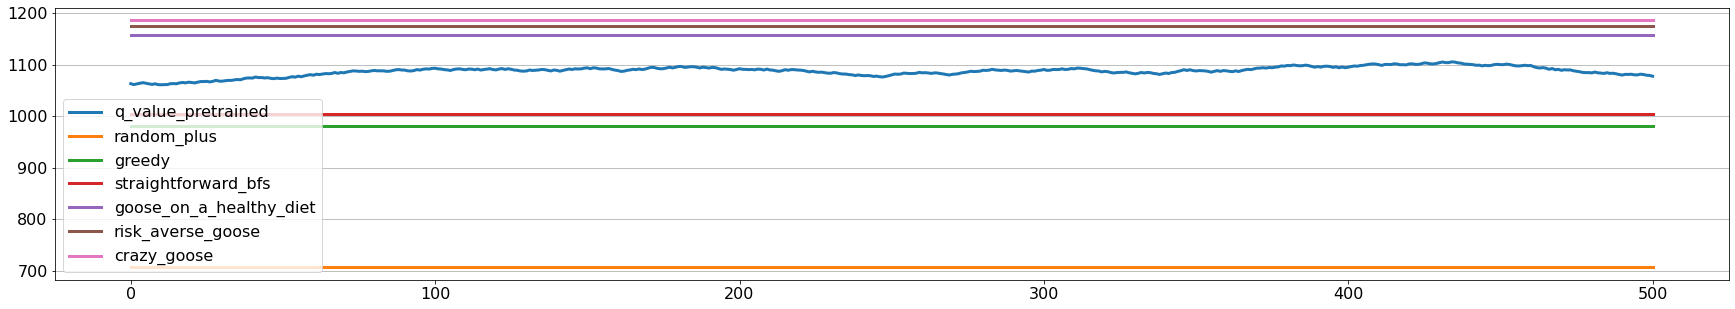

In [17]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/02_epsilon002_reward_-4_4_x128/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1114
straightforward_bfs,1004
greedy,981
random_plus,706


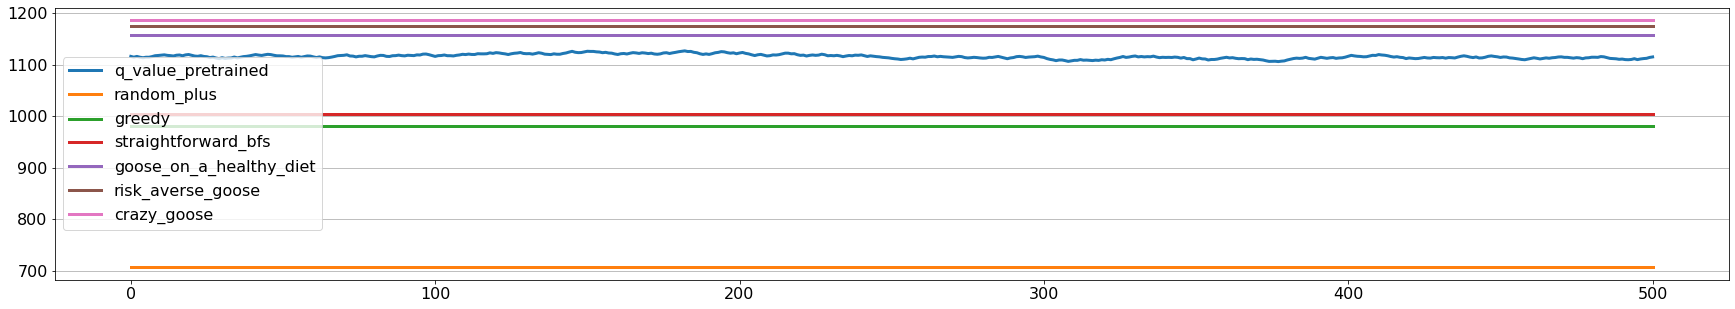

In [18]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/04_epsilon002_reward_-4_4_x128_generator_data_augmentation/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1119
straightforward_bfs,1004
greedy,981
random_plus,706


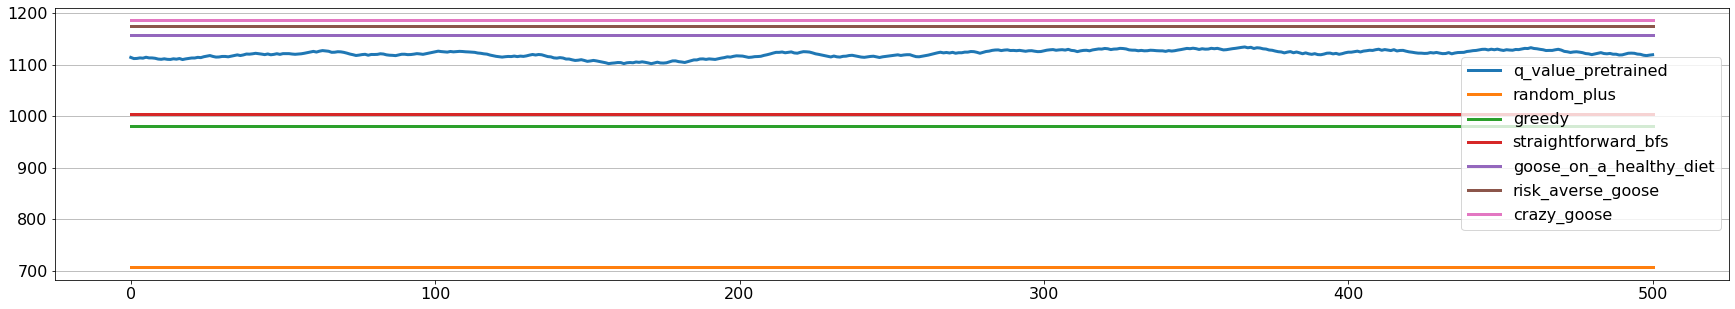

In [15]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/05_epsilon002_reward_-4_4_x128_generator_more_data_augmentation/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
crazy_goose,1186
risk_averse_goose,1176
goose_on_a_healthy_diet,1157
q_value_pretrained,1108
straightforward_bfs,1004
greedy,981
random_plus,706


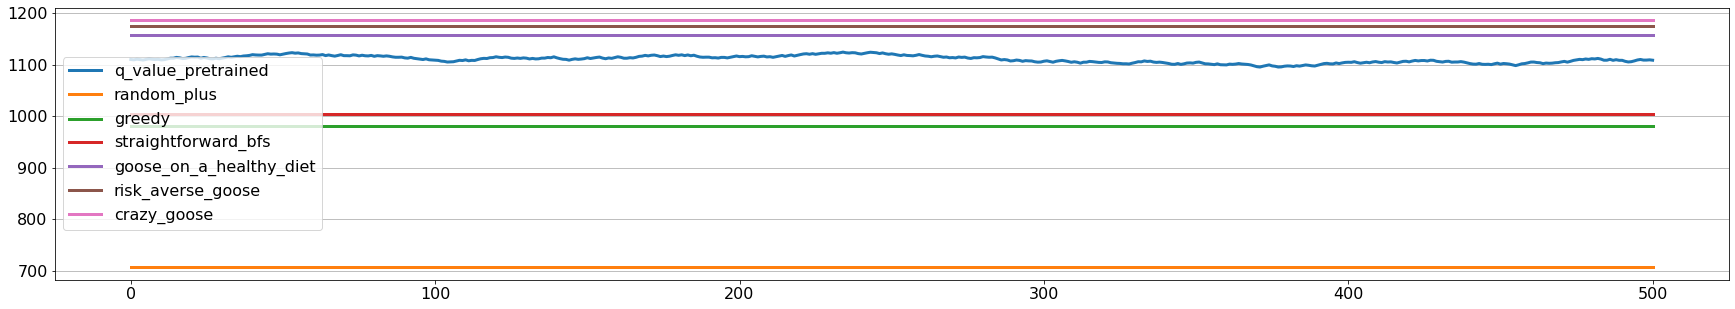

In [11]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/06_epsilon002_reward_-4_4_x256_generator_more_data_augmentation/q_value_agent.py'},
    ['random_plus', 'greedy', 'straightforward_bfs', 'goose_on_a_healthy_diet', 'risk_averse_goose', 'crazy_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

#### Play against risk_averse_goose

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
risk_averse_goose,1176
q_value_pretrained,1136


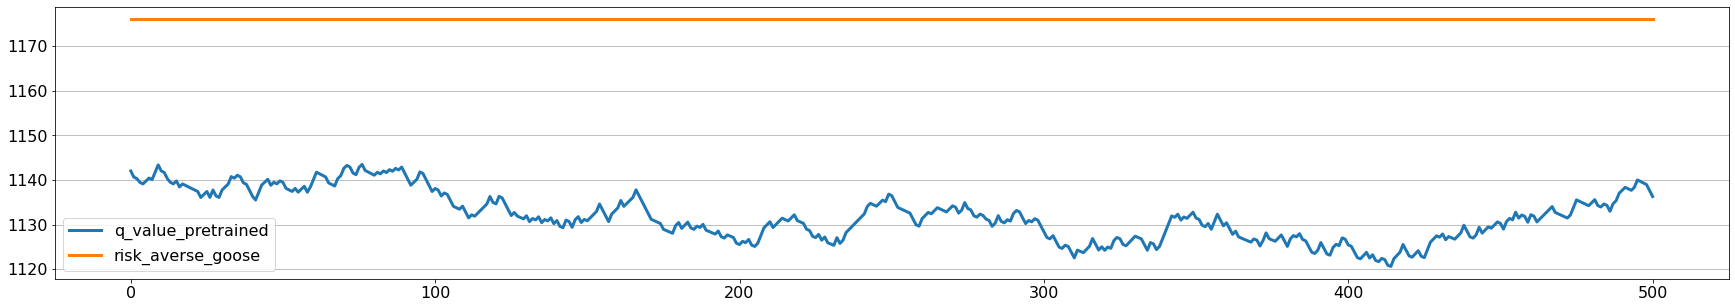

In [21]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/01_epsilon002_reward_-4_4_x16/q_value_agent.py'},
    ['risk_averse_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
risk_averse_goose,1176
q_value_pretrained,1140


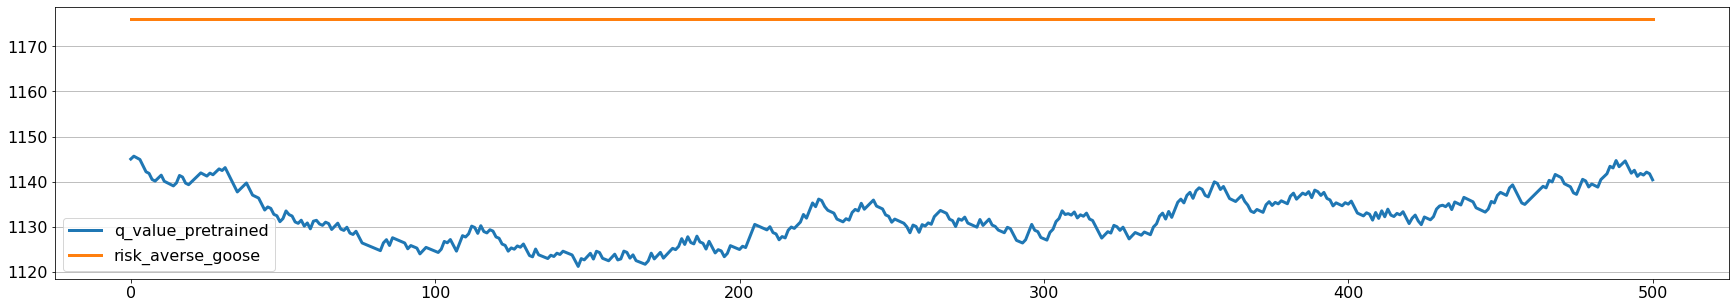

In [20]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/02_epsilon002_reward_-4_4_x128/q_value_agent.py'},
    ['risk_averse_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
risk_averse_goose,1176
q_value_pretrained,1175


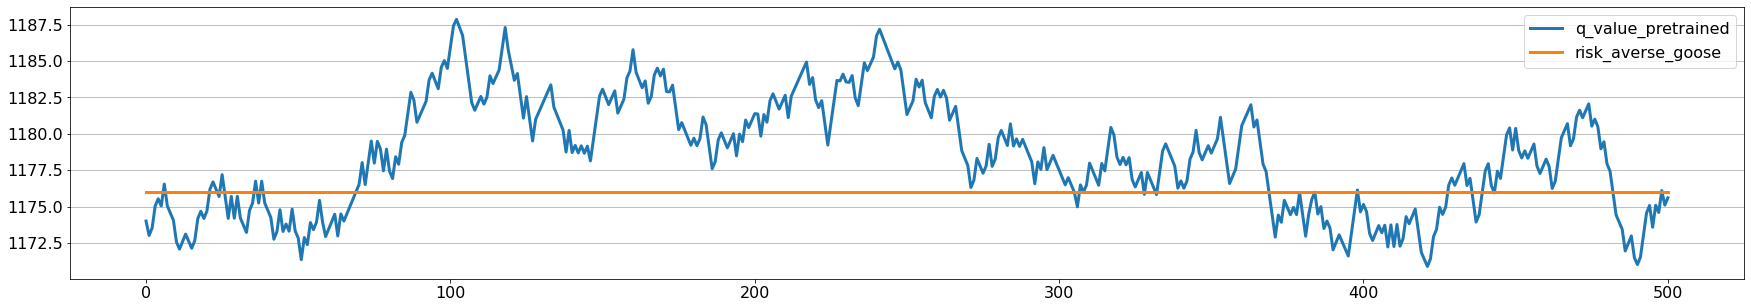

In [19]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/05_epsilon002_reward_-4_4_x128_generator_more_data_augmentation/q_value_agent.py'},
    ['risk_averse_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

This is interesting, if I play only against risk_averse_goose then the agent achieves a comparable score.

  0%|          | 0/500 [00:00<?, ?it/s]

,ranking
q_value_pretrained,1187
risk_averse_goose,1176


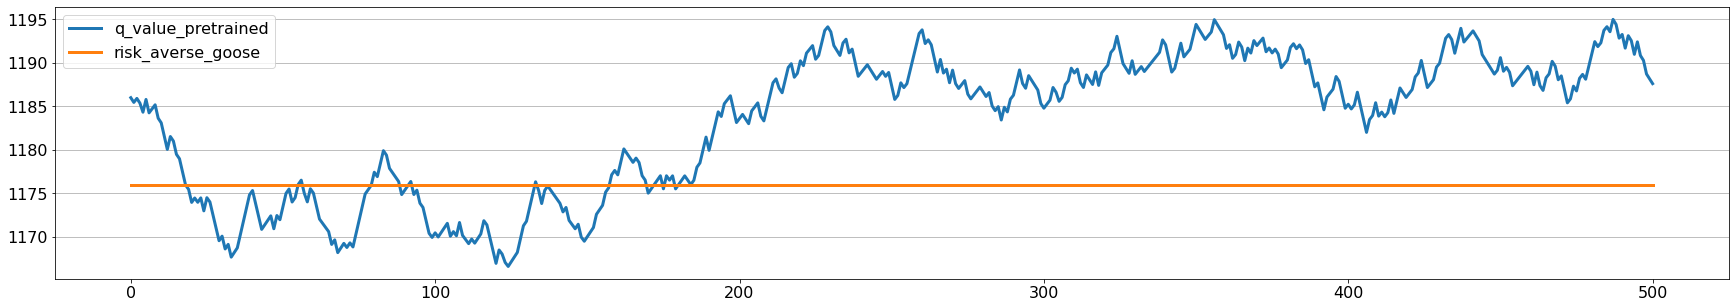

In [14]:
ret = evaluate_agent(
    {'q_value_pretrained': '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/06_epsilon002_reward_-4_4_x256_generator_more_data_augmentation/q_value_agent.py'},
    ['risk_averse_goose'],
    n_matches=500, single_agent=True, max_workers=20)
compute_elo_ranking(*ret)

#### Game visualization

In [45]:
model_path = '/mnt/hdd0/Kaggle/hungry_geese/models/19_risk_averse_goose/06_epsilon002_reward_-4_4_x256_generator_more_data_augmentation/best_model.h5'
model = tf.keras.models.load_model(model_path, compile=False)
model = tf.keras.models.Model(inputs=model.inputs[:2], outputs=model.get_layer('action').output)
q_value_agent = QValueAgent(model)

In [46]:
env = make('hungry_geese')
env.run([q_value_agent] + ['../forum/agents/risk_averse_goose.py']*3);

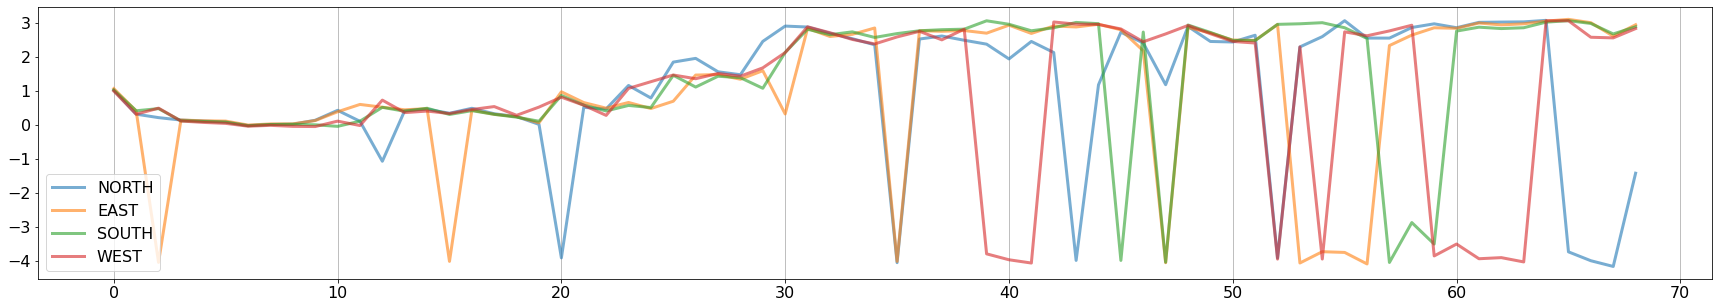

In [66]:
plot_q_value(q_value_agent)

In [52]:
env.render(mode="ipython")

I can see that it does not model the danger correctly. For example when there is a goose head in the upper right corner then the other goose can move to two locations, so I should see danger in both locations, but I only see danger in one. This may mean that I need more exploration and/or maybe more variability on the other agents.

Also it seems to be very inmediate when predicting the value, does not seem to look too much into the future.

## Verify that data is created correctly

In [10]:
game_path = '/mnt/hdd0/Kaggle/hungry_geese/games/epsilon_risk_averse_goose_002_vs_risk_averse_goose_matches_100.json'
with open(game_path, 'r') as f:
    matches_results = json.load(f)

In [13]:
def get_game_state(match, agent_idx):
    env = make("hungry_geese")
    conf = env.configuration

    state = GameState(egocentric_board=False)
    for step_idx, step in enumerate(match):
        observation = step[0]['observation'].copy()
        observation['index'] = agent_idx
        state.update(observation, conf)
        if step_idx:
            state.add_action(step[agent_idx]['action'])
        if not observation['geese'][agent_idx]:
            break
    return state

In [14]:
def show_movement_sequence(state, start_idx, end_idx):
    for step_idx in range(start_idx, end_idx):
        render = state.render_board(state.boards[step_idx])
        plt.subplot(1, end_idx - start_idx, step_idx - start_idx +1)
        plt.imshow(render)
        plt.title(state.actions[step_idx])
        plt.grid(which='both'); plt.yticks(np.arange(-0.5, 6.5),[]);  plt.xticks(np.arange(-0.5, 10.5),[])

In [ ]:
state = get_game_state(matches_results[0], agent_idx=0)

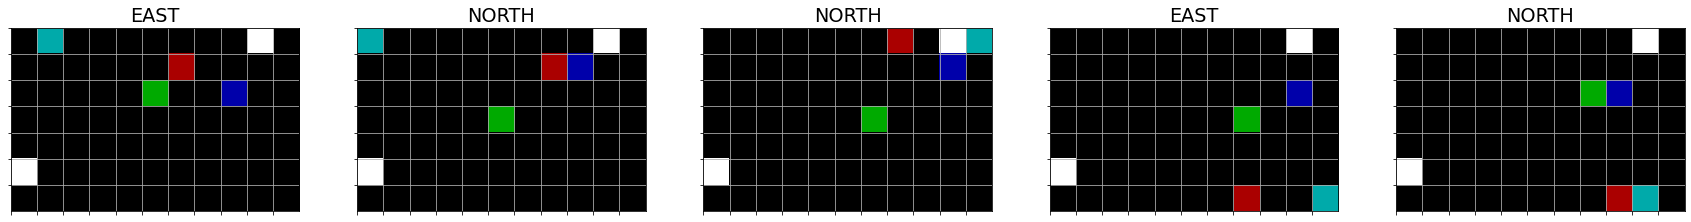

In [23]:
show_movement_sequence(state, start_idx=0, end_idx=5)

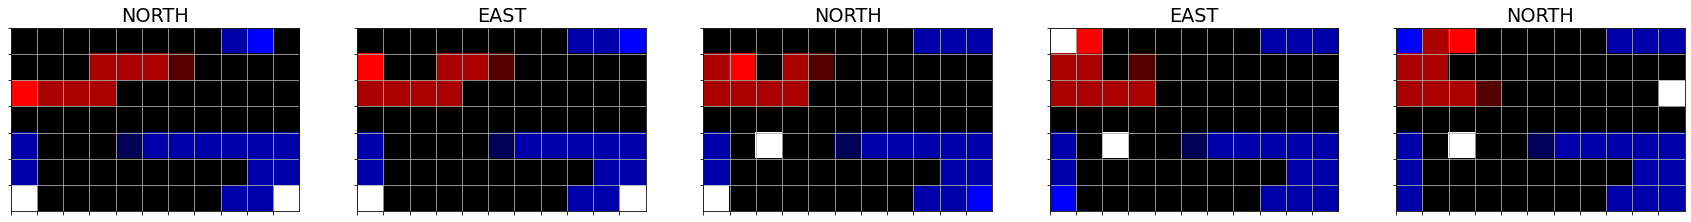

In [27]:
show_movement_sequence(state, start_idx=109, end_idx=114)

Seems to be working perfectly.

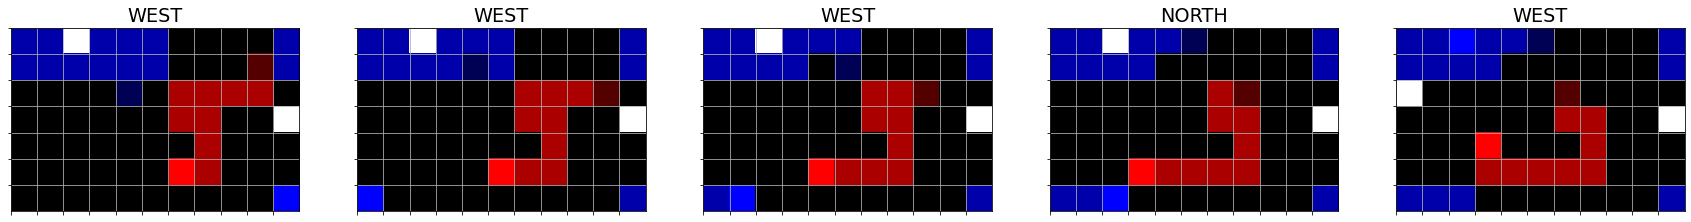

In [29]:
state = get_game_state(matches_results[1], agent_idx=0)
show_movement_sequence(state, start_idx=(len(state.actions)-5), end_idx=len(state.actions))

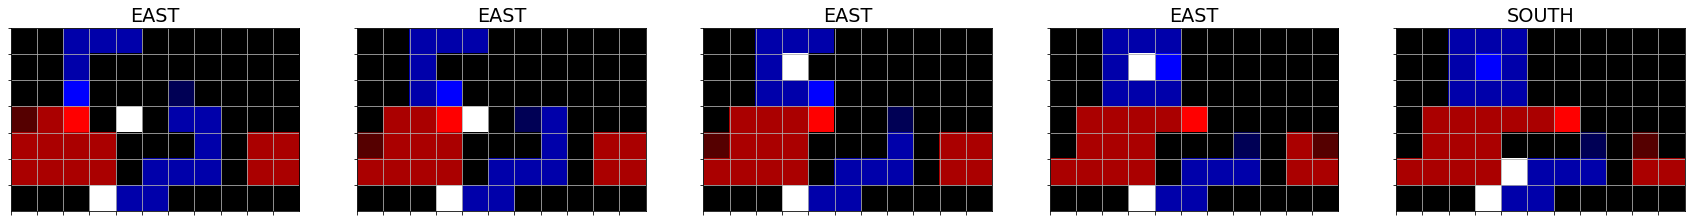

In [30]:
state = get_game_state(matches_results[2], agent_idx=0)
show_movement_sequence(state, start_idx=(len(state.actions)-5), end_idx=len(state.actions))

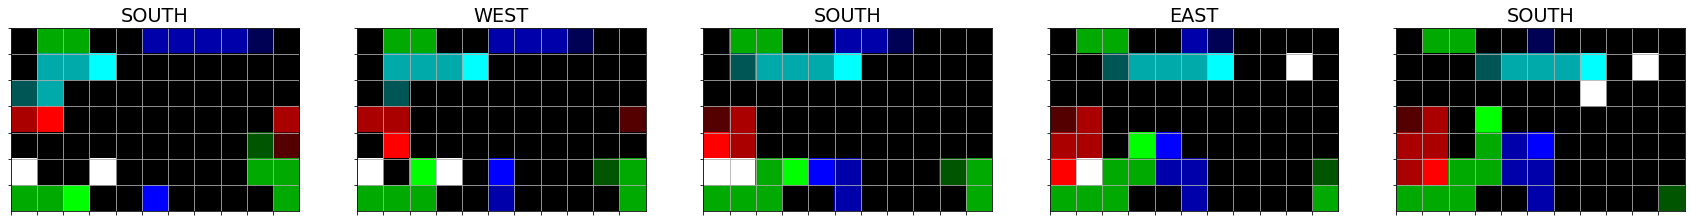

In [31]:
state = get_game_state(matches_results[3], agent_idx=0)
show_movement_sequence(state, start_idx=(len(state.actions)-5), end_idx=len(state.actions))

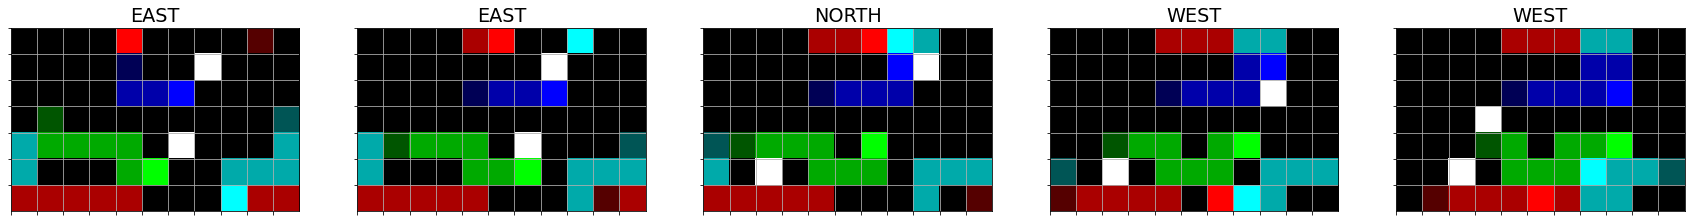

In [32]:
state = get_game_state(matches_results[4], agent_idx=0)
show_movement_sequence(state, start_idx=(len(state.actions)-5), end_idx=len(state.actions))

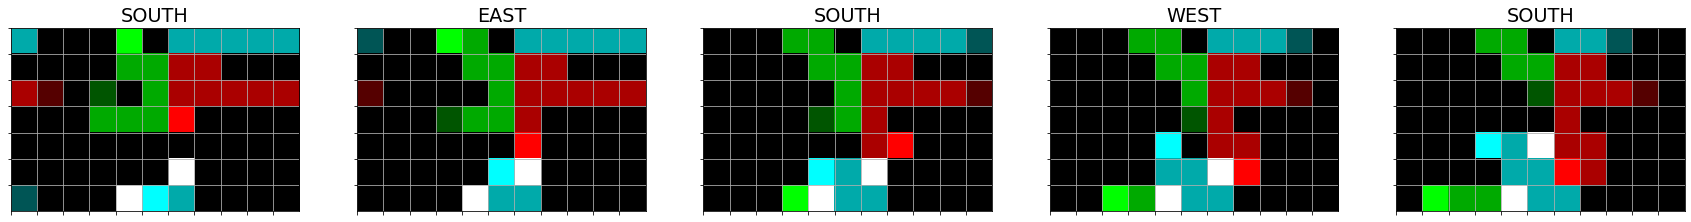

In [33]:
state = get_game_state(matches_results[5], agent_idx=0)
show_movement_sequence(state, start_idx=(len(state.actions)-5), end_idx=len(state.actions))

There does not seem to be any error with the data and the actions.

## Summary